# Load Data

Oxford 102 Flower is an image classification dataset consisting of 102 flower categories.
The flowers were chosen to be flowers commonly occurring in the United Kingdom.
Each class consists of between 40 and 258 images.

The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category, and several very similar categories.


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

# CNN 
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# others
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import time

# dataset 
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import Flowers102

# label 
from scipy.io import loadmat
import json

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
batch_size = 4
data_dir = '../../Data/flowers-102'

# Prepare Labels' Name


In [3]:
json_data = '{"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt\'s foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}'
# load data 
cat_to_name = json.loads(json_data)
# convert to int
cat_to_name = {int(k)-1:v for k,v in cat_to_name.items()}
# sort by key
class_names = dict(sorted(cat_to_name.items()))
print(class_names)

{0: 'pink primrose', 1: 'hard-leaved pocket orchid', 2: 'canterbury bells', 3: 'sweet pea', 4: 'english marigold', 5: 'tiger lily', 6: 'moon orchid', 7: 'bird of paradise', 8: 'monkshood', 9: 'globe thistle', 10: 'snapdragon', 11: "colt's foot", 12: 'king protea', 13: 'spear thistle', 14: 'yellow iris', 15: 'globe-flower', 16: 'purple coneflower', 17: 'peruvian lily', 18: 'balloon flower', 19: 'giant white arum lily', 20: 'fire lily', 21: 'pincushion flower', 22: 'fritillary', 23: 'red ginger', 24: 'grape hyacinth', 25: 'corn poppy', 26: 'prince of wales feathers', 27: 'stemless gentian', 28: 'artichoke', 29: 'sweet william', 30: 'carnation', 31: 'garden phlox', 32: 'love in the mist', 33: 'mexican aster', 34: 'alpine sea holly', 35: 'ruby-lipped cattleya', 36: 'cape flower', 37: 'great masterwort', 38: 'siam tulip', 39: 'lenten rose', 40: 'barbeton daisy', 41: 'daffodil', 42: 'sword lily', 43: 'poinsettia', 44: 'bolero deep blue', 45: 'wallflower', 46: 'marigold', 47: 'buttercup', 48:

# Task 1

1. Check out the torchvision datasets of PyTorch and decide one dataset that you want to use (no
   CIFAR, no ImageNet, no FashionMNIST).


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_datasets = Flowers102(root=data_dir+"/train", split="train", download=True, transform=data_transforms["train"])
val_datasets = Flowers102(root=data_dir+"/val", split="val", download=True, transform=data_transforms["val"])

image_datasets = {x: Flowers102(root=data_dir, split=x, download=True, transform=data_transforms[x])
                    for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print("dataset_sizes: ",dataset_sizes)
print("device: ",device)
print("image_datasets function call: ", dir(image_datasets["train"]))
print("class_names: ", class_names)

dataset_sizes:  {'train': 1020, 'val': 1020}
device:  mps
image_datasets function call:  ['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_base_folder', '_check_integrity', '_download_url_prefix', '_file_dict', '_format_transform_repr', '_image_files', '_images_folder', '_is_protocol', '_labels', '_repr_indent', '_split', '_splits_map', 'download', 'extra_repr', 'root', 'target_transform', 'transform', 'transforms']
class_names:  {0: 'pink primrose', 1: 'hard-leaved pocket orchid', 2: 'canterbury bells', 3: 'sweet pea', 4: 'english marigold', 5: 'tiger li

# Task 2

2. Show some example images of the dataset in the notebook and print the dataset size.


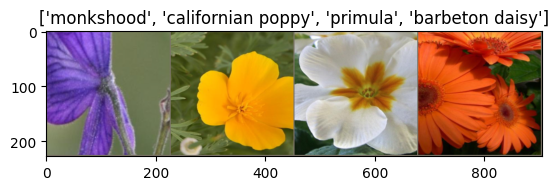

In [14]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])


In [15]:
print(inputs.shape)
print("dataset_sizes: ",dataset_sizes)

torch.Size([4, 3, 224, 224])
dataset_sizes:  {'train': 1020, 'val': 1020}


# Task 3

3. Design a CNN to predict on the dataset. Use a similar architecture like last time, but this time
   also include batch normalization layers.

**What we do:**

- We put the batch normalization layers after each convolutional layer and before the activation\*\*
- Because we were facing "Invalida Buffer size: 21.95 GB" problem, so we make the model more samller.


In [ ]:
import torch.nn as nn

class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        # Layer 1: 3x3 kernel，depth = 32，224-3+1=222 => 222x222 pixel
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.5)  # 添加Dropout層

        # Layer 2: Max pooling with 2x2 kernel，222/2=111 => 111x111 pixel
        self.pool = nn.MaxPool2d(2, 2)

        # Layer 3: 3x3 kernel，depth = 64，111-3+1=109 => 109x109 pixel
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.5)  # 添加Dropout層

        # Layer 4: Max pooling with 2x2 kernel，109/2=54 => 54x54 pixel
        self.pool = nn.MaxPool2d(2, 2)

        # Layer 5: 3x3 kernel，depth = 128，54-3+1=52 => 52x52 pixel
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.5)  # 添加Dropout層

        # Layer 6: Max pooling with 2x2 kernel，52/2=26 => 26x26 pixel
        self.pool = nn.MaxPool2d(2, 2)
        
        # Final input is 512，pixel is 26*26 => 128*26*26
        self.fc1 = nn.Linear(128 * 26 * 26, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 102)

    def forward(self, x):
        # We put the batch normalization before the activation function. 
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)  # 在池化之後應用Dropout
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)  # 在池化之後應用Dropout
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)  # 在池化之後應用Dropout
        x = x.view(-1, 128 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = NewNet()
net.to(device)


# Task 4

4. Train the model on the dataset and measure the accuracy on hold out test data.


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# adam 
# optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
def train(epoch, start_time):
    net.train()
    cur_count = 0 
    running_loss = 0.0
    for batch_idx, data in enumerate(dataloaders["train"], 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        cur_count += len(data)
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs.to(device)
        
        loss = criterion(outputs, labels)
        loss.to(device)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print(f'[{epoch}, {batch_idx + 1:5d}] loss: {running_loss / 100:.3f} time elapsed: {round((time.time() - start_time))} sec.')
            running_loss = 0.0

In [ ]:
def test(): 
    net.eval()  # set model to evaluation mode
    correct = 0
    total = 0
    class_correct = [0] * len(class_names)  
    class_total = [0] * len(class_names)  
    with torch.no_grad():
        for data in dataloaders["val"]:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images) 

            # select top 3 predictions
            _, predicted = torch.topk(outputs, 1, dim=1)
            
            # check if predicted labels are in true labels
            for i in range(len(labels)):
                # print(f'Predicted index {i}: {predicted[i]} Actual: {labels[i]} \t Correct: {labels[i] in predicted[i]}')
                total += 1
                class_total[labels[i]] += 1

                if labels[i] in predicted[i]:
                    correct += 1
                    class_correct[labels[i]] += 1

    class_accuracies = [class_correct[i] / class_total[i] for i in range(len(class_names))]
    accuracy = correct / total
    return accuracy, class_accuracies

In [ ]:
last_epoch = 100
PATH = './nb_intput_128_26_26_neuron_2048_epoch_{}.pth'.format(last_epoch)
net = NewNet()
net.to(device)
net.load_state_dict(torch.load(PATH)) # load the weights from the saved file

# Training

- Epoch 1 ~ 100 without dropout + SGD + lr:0.001 : Testing accuracy: 0.3559


In [ ]:
num_epochs = 40
start_time = time.time()

accuracy, class_accuracies = test()
print(f'Accuracy on test data (top-1): {100 * accuracy:.2f}%')
for epoch in range(last_epoch+1, last_epoch + num_epochs + 1):
    print(f"============ Epoch: {epoch} ==========")
    train(epoch, start_time)
    
    if epoch % 5 == 0:
        accuracy, class_accuracies = test()
        # print accuracies
        print(f'Accuracy on test data (top-1): {100 * accuracy:.2f}%')

    if epoch % 10 == 0: 
        PATH = './nb_intput_128_26_26_neuron_2048_epoch_{}.pth'.format(epoch)
        torch.save(net.state_dict(), PATH)  

print(f'Finished Training. Total elapsed time: {round((time.time() - start_time) / 60, 1)} min')

# Task 5

Task 5. Now use transfer learning to use a pre-trained ResNet18 on the dataset as follows:

1. ResNet18 as fixed feature extractor.
2. ResNet18 finetuned on the training data.


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time elapsed: {round((time.time() - since))} sec.')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [41]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# num_ftrs is the number of input features for the last layer. 
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 102.
# model_ft.fc is the final layer of the model, and used for classification.
model_ft.fc = nn.Linear(num_ftrs, 102)
model_ft = model_ft.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.4280 Acc: 0.0657 Time elapsed: 33 sec.
val Loss: 2.9901 Acc: 0.3118 Time elapsed: 58 sec.

Epoch 1/24
----------
train Loss: 3.3046 Acc: 0.2353 Time elapsed: 87 sec.
val Loss: 1.6604 Acc: 0.5941 Time elapsed: 112 sec.

Epoch 2/24
----------
train Loss: 2.5080 Acc: 0.4029 Time elapsed: 141 sec.
val Loss: 1.2243 Acc: 0.6951 Time elapsed: 166 sec.

Epoch 3/24
----------
train Loss: 1.9871 Acc: 0.5196 Time elapsed: 195 sec.
val Loss: 0.9578 Acc: 0.7216 Time elapsed: 219 sec.

Epoch 4/24
----------
train Loss: 1.5865 Acc: 0.6225 Time elapsed: 249 sec.
val Loss: 0.6911 Acc: 0.8108 Time elapsed: 273 sec.

Epoch 5/24
----------
train Loss: 1.3612 Acc: 0.7108 Time elapsed: 302 sec.
val Loss: 0.6706 Acc: 0.8118 Time elapsed: 326 sec.

Epoch 6/24
----------
train Loss: 1.1785 Acc: 0.7373 Time elapsed: 355 sec.
val Loss: 0.6328 Acc: 0.8294 Time elapsed: 379 sec.

Epoch 7/24
----------
train Loss: 0.9143 Acc: 0.8275 Time elapsed: 408 sec.
val Loss: 0.5249 Acc: 0.

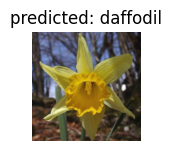

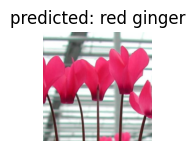

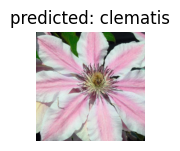

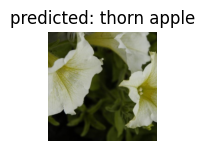

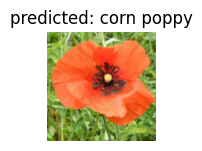

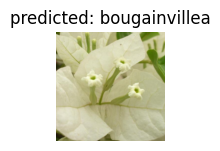

In [20]:
visualize_model(model_ft)

In [16]:
PATH = './resnet18_{}.pth'.format("IMAGENET1K_V1")
torch.save(model_ft.state_dict(), PATH)  

In [10]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 102)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv_SGD = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.6979 Acc: 0.0176 Time elapsed: 24 sec.
val Loss: 3.9863 Acc: 0.1235 Time elapsed: 48 sec.

Epoch 1/24
----------
train Loss: 4.0589 Acc: 0.1137 Time elapsed: 72 sec.
val Loss: 3.1125 Acc: 0.3608 Time elapsed: 95 sec.

Epoch 2/24
----------
train Loss: 3.4935 Acc: 0.2304 Time elapsed: 119 sec.
val Loss: 2.5003 Acc: 0.4912 Time elapsed: 142 sec.

Epoch 3/24
----------
train Loss: 3.1030 Acc: 0.3422 Time elapsed: 165 sec.
val Loss: 2.1583 Acc: 0.5510 Time elapsed: 189 sec.

Epoch 4/24
----------
train Loss: 2.7367 Acc: 0.4402 Time elapsed: 212 sec.
val Loss: 1.7064 Acc: 0.6304 Time elapsed: 236 sec.

Epoch 5/24
----------
train Loss: 2.3854 Acc: 0.5275 Time elapsed: 260 sec.
val Loss: 1.5318 Acc: 0.6873 Time elapsed: 283 sec.

Epoch 6/24
----------
train Loss: 2.2016 Acc: 0.5500 Time elapsed: 307 sec.
val Loss: 1.3164 Acc: 0.7069 Time elapsed: 330 sec.

Epoch 7/24
----------
train Loss: 1.9511 Acc: 0.6755 Time elapsed: 354 sec.
val Loss: 1.2236 Acc: 0.7

In [12]:
PATH = './resnet18_conv_{}.pth'.format("IMAGENET1K_V1")
torch.save(model_conv_SGD.state_dict(), PATH)  

# Use our own fully connected layer 

In [10]:
class FFClassifier(nn.Module):
     def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 4096)
        self.fc2 = nn.Linear(4096, out_features)
     def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x 

model_conv = models.resnet18(weights='IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = FFClassifier(num_ftrs,102)

model_conv = model_conv.to(device)

# Criteria NLLLoss is recommended with softmax info layer 
criteria = nn.NLLLoss()

optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.001)
sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)


In [11]:
model_conv_Adam = train_model(model_conv, criteria, optimizer, sched,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.7188 Acc: 0.0108 Time elapsed: 26 sec.
val Loss: 4.5080 Acc: 0.0343 Time elapsed: 49 sec.

Epoch 1/24
----------
train Loss: 4.4242 Acc: 0.0382 Time elapsed: 73 sec.
val Loss: 3.9980 Acc: 0.0637 Time elapsed: 96 sec.

Epoch 2/24
----------
train Loss: 4.1589 Acc: 0.0422 Time elapsed: 121 sec.
val Loss: 3.6365 Acc: 0.1500 Time elapsed: 144 sec.

Epoch 3/24
----------
train Loss: 3.8421 Acc: 0.1020 Time elapsed: 168 sec.
val Loss: 3.2658 Acc: 0.2324 Time elapsed: 191 sec.

Epoch 4/24
----------
train Loss: 3.5853 Acc: 0.1520 Time elapsed: 216 sec.
val Loss: 3.1680 Acc: 0.2706 Time elapsed: 239 sec.

Epoch 5/24
----------
train Loss: 3.5379 Acc: 0.1657 Time elapsed: 263 sec.
val Loss: 3.0965 Acc: 0.2706 Time elapsed: 286 sec.

Epoch 6/24
----------
train Loss: 3.4645 Acc: 0.1833 Time elapsed: 311 sec.
val Loss: 3.0088 Acc: 0.3088 Time elapsed: 334 sec.

Epoch 7/24
----------
train Loss: 3.4342 Acc: 0.1892 Time elapsed: 358 sec.
val Loss: 2.9665 Acc: 0.3

# Task 6
6. Repeat step 4 but now use EfficientNet_B5 instead of RestNet18.

In [12]:
from efficientnet_pytorch import EfficientNet

use_previous_net_as_fixed_feature_extractor = True

# Load the pre-trained EfficientNet-B5 model
# model_ft = EfficientNet.from_pretrained('efficientnet-b5', num_classes=102)
model_ft = models.efficientnet_b5(pretrained=True)

last_layer = model_ft.classifier[1]
num_ftrs = last_layer.in_features

model_ft.classifier[1] = nn.Linear(num_ftrs, 102)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters which are passed to the optimizer are being optimized
optimizer_ft = optim.SGD((model_ft.classifier[1].parameters()) if use_previous_net_as_fixed_feature_extractor else model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = model_ft.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /Users/shannon/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100.0%


Loaded pretrained weights for efficientnet-b5


In [13]:
model_ft_effb5 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.5830 Acc: 0.0265 Time elapsed: 138 sec.
val Loss: 4.4976 Acc: 0.1245 Time elapsed: 175 sec.

Epoch 1/24
----------
train Loss: 4.3981 Acc: 0.1333 Time elapsed: 282 sec.
val Loss: 4.3307 Acc: 0.3039 Time elapsed: 318 sec.

Epoch 2/24
----------
train Loss: 4.1099 Acc: 0.2833 Time elapsed: 425 sec.
val Loss: 4.0640 Acc: 0.4510 Time elapsed: 462 sec.

Epoch 3/24
----------
train Loss: 3.7572 Acc: 0.3461 Time elapsed: 569 sec.
val Loss: 3.7589 Acc: 0.5559 Time elapsed: 605 sec.

Epoch 4/24
----------
train Loss: 3.3581 Acc: 0.4206 Time elapsed: 712 sec.
val Loss: 3.3857 Acc: 0.6088 Time elapsed: 748 sec.

Epoch 5/24
----------
train Loss: 2.9709 Acc: 0.4696 Time elapsed: 855 sec.
val Loss: 3.0514 Acc: 0.6294 Time elapsed: 892 sec.

Epoch 6/24
----------
train Loss: 2.6037 Acc: 0.5284 Time elapsed: 999 sec.
val Loss: 2.7226 Acc: 0.6716 Time elapsed: 1035 sec.

Epoch 7/24
----------
train Loss: 2.3236 Acc: 0.5882 Time elapsed: 1142 sec.
val Loss: 2.7029 Ac

In [17]:
PATH = './efficientnet-b5.pth'
torch.save(model_ft_effb5.state_dict(), PATH)  